# Analysis for EWG

In [1]:
import anduryl
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
# plt.style.use('default')
%matplotlib inline

### Create project and explore answers

In [2]:
# Create project and load Excalibur files
file = 'Dieren'
project = anduryl.Project()
# project.io.load_json(f'./{file}.json')
project.io.load_excalibur(f'./{file}.dtt', f'./{file}.rls')
project

Main project class.
Properties:
 - assessments
 - experts
 - io
 - items
 - main_results
 - results
Methods:
 - add_results_from_settings
 - calculate_decision_maker
 - calculate_expert_robustness
 - calculate_item_robustness
 - initialize
 - to_results

Note: The properties contain the information about the realization, experts and scores. The methods can be applied to the different properties in order to perform different analyses. For example, obtaining the scores or a decision maker. 

In [3]:
# See the items in the project

pd.DataFrame.from_dict(project.items.as_dict())

,scale,realization,question,unit
item00,uni,11.95,,
item01,uni,202.00,,
item02,uni,4.25,,
item03,uni,2.58,,
item04,uni,113.00,,
item05,uni,15.00,,
item06,uni,0.55,,
item07,uni,18.20,,
item08,uni,23.90,,
item09,uni,60.35,,


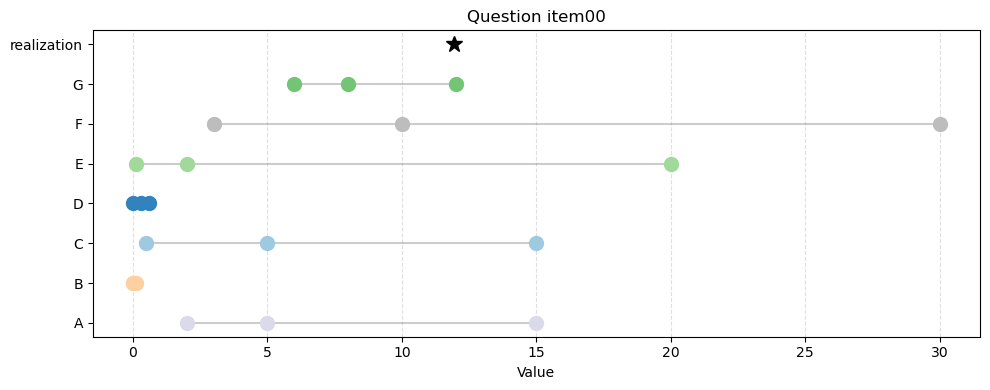

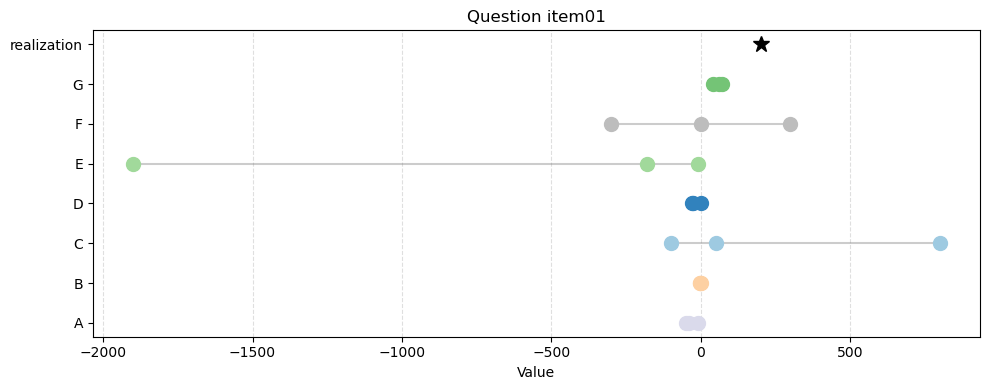

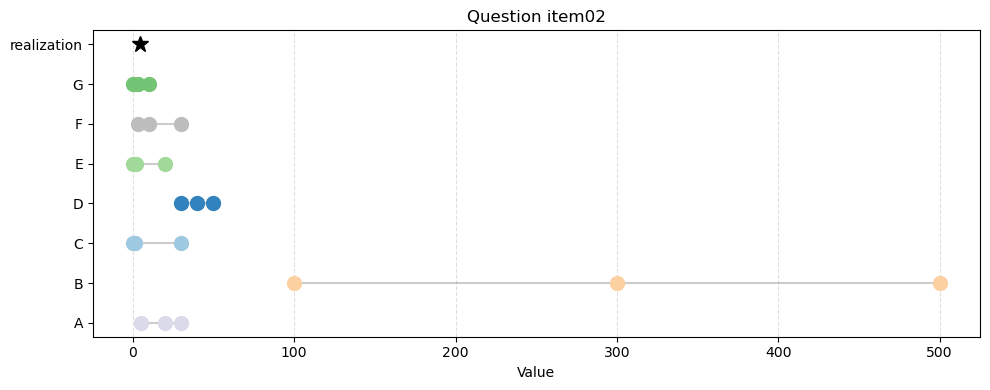

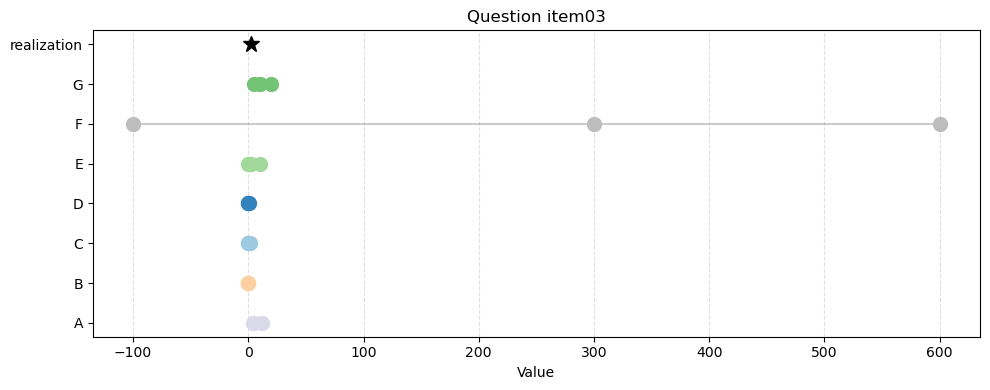

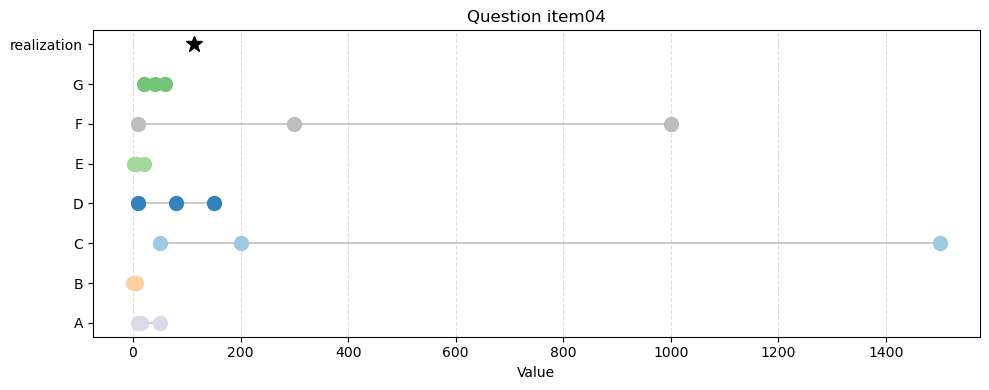

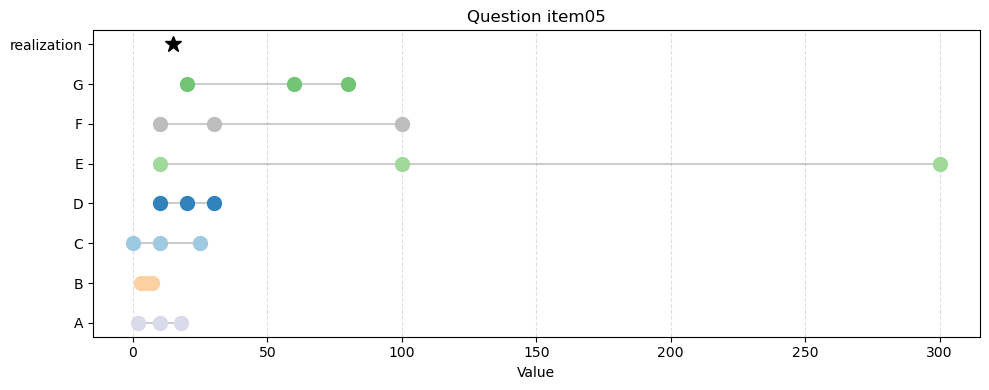

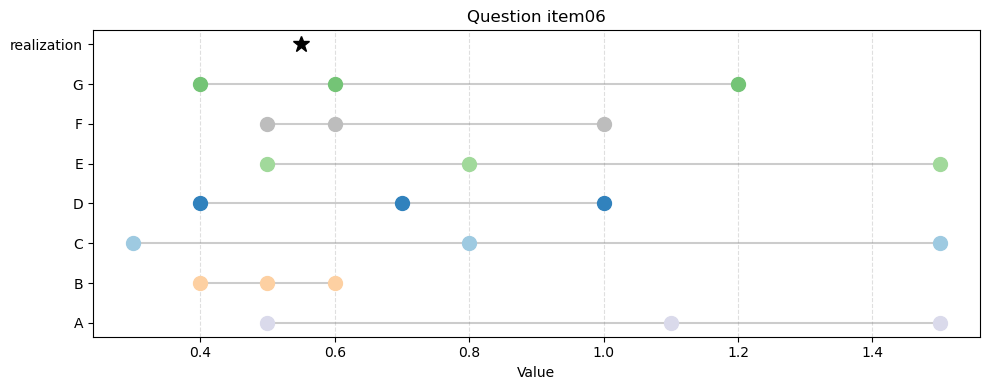

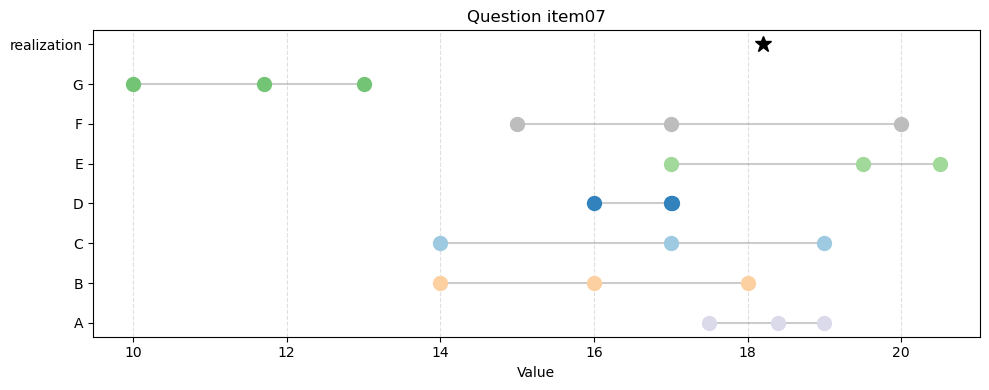

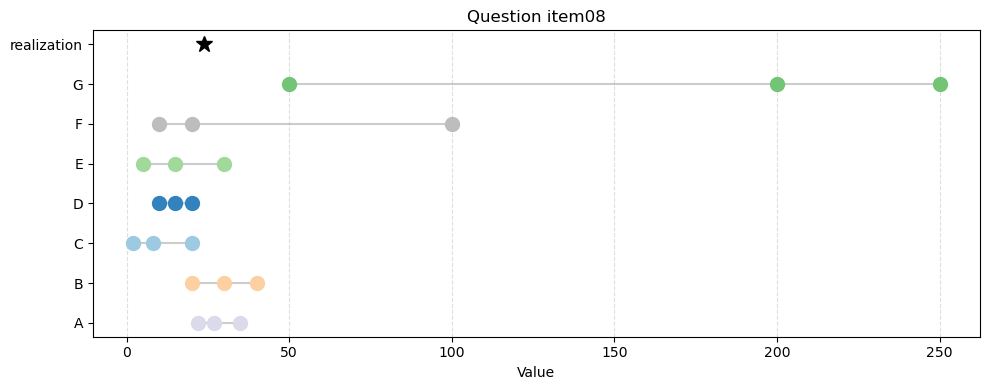

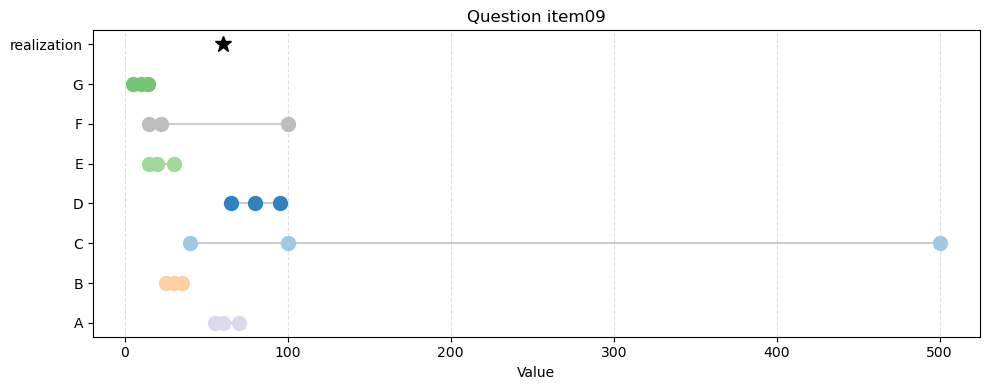

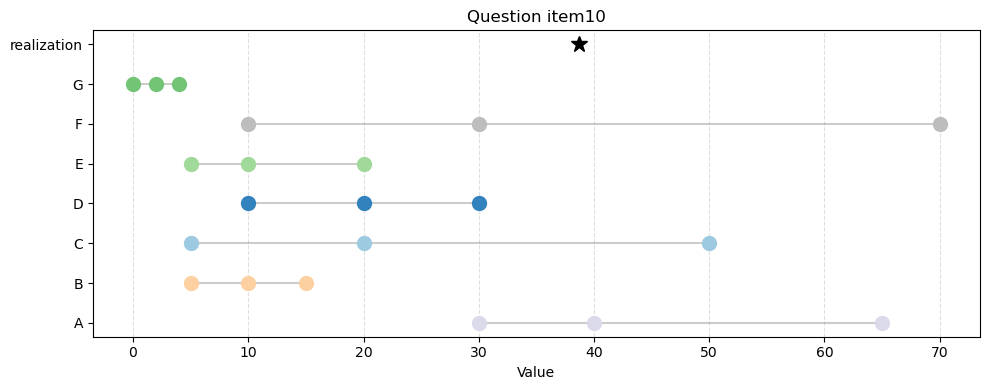

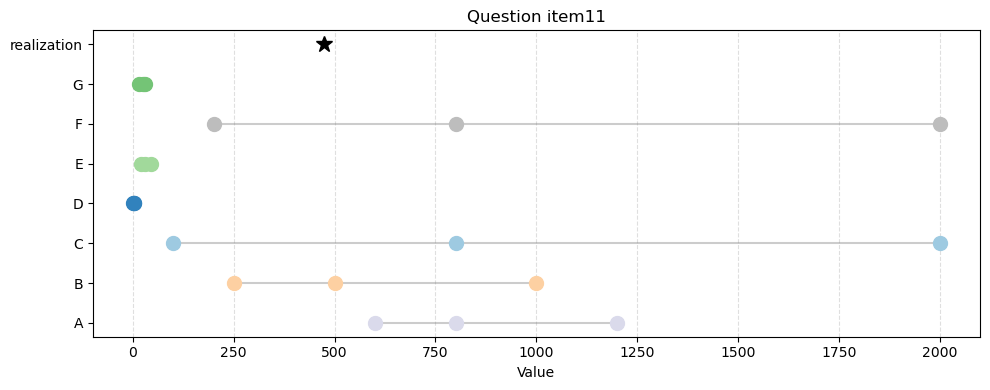

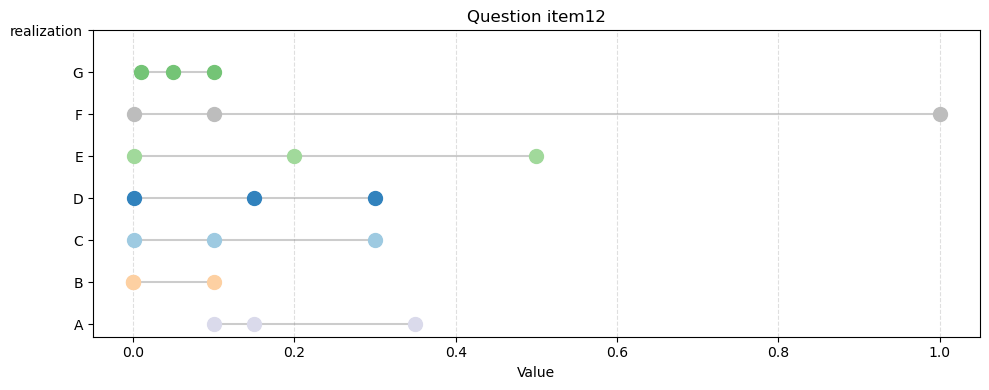

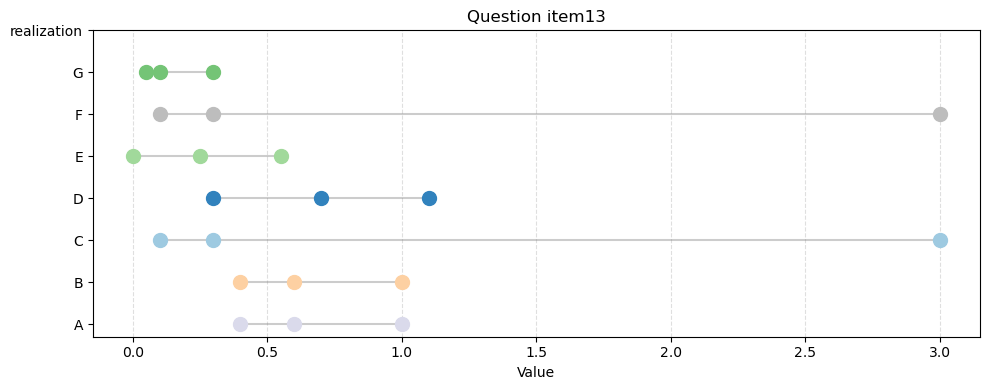

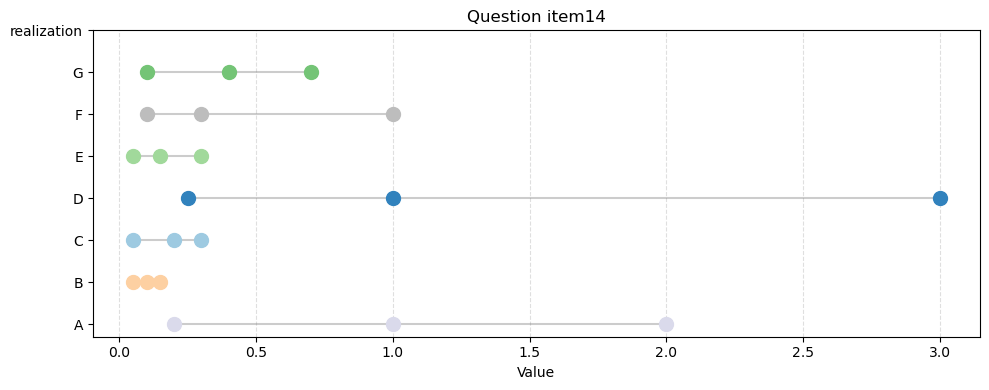

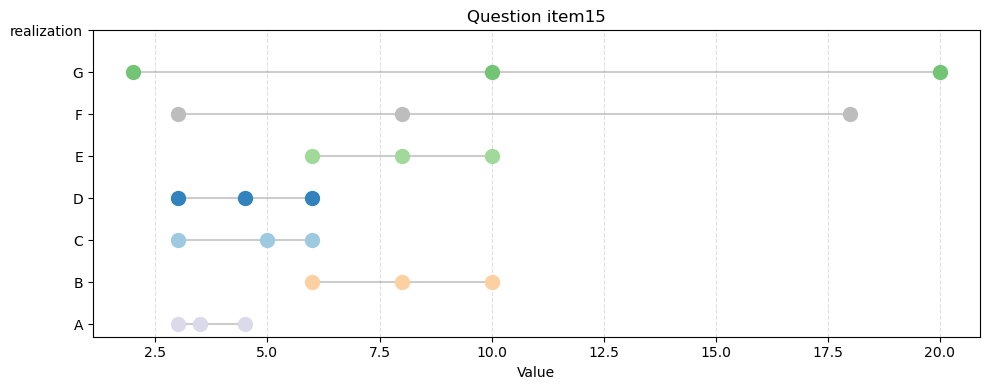

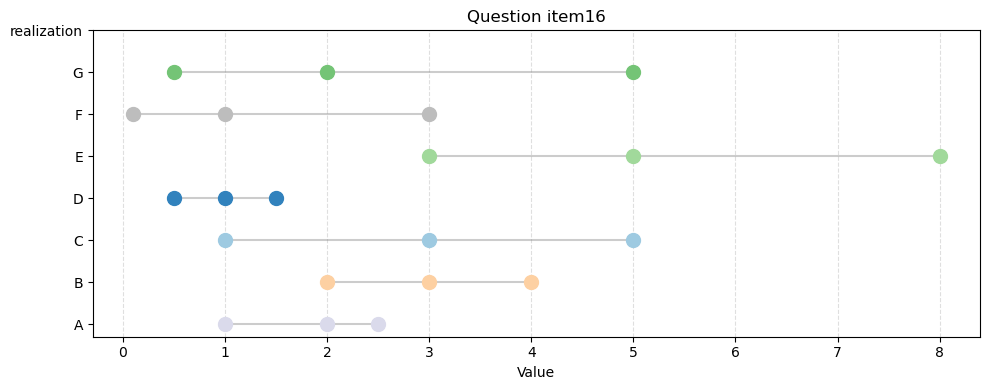

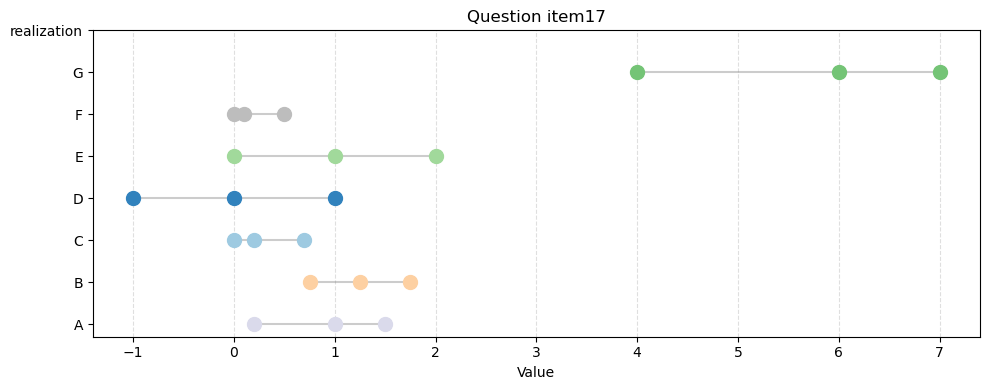

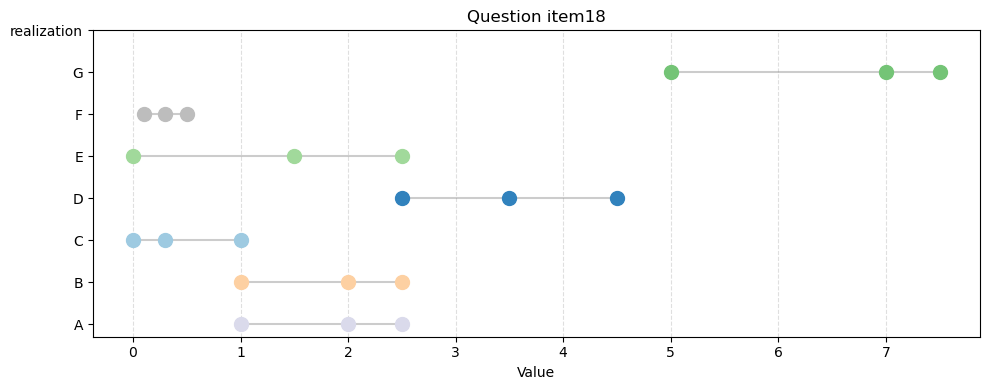

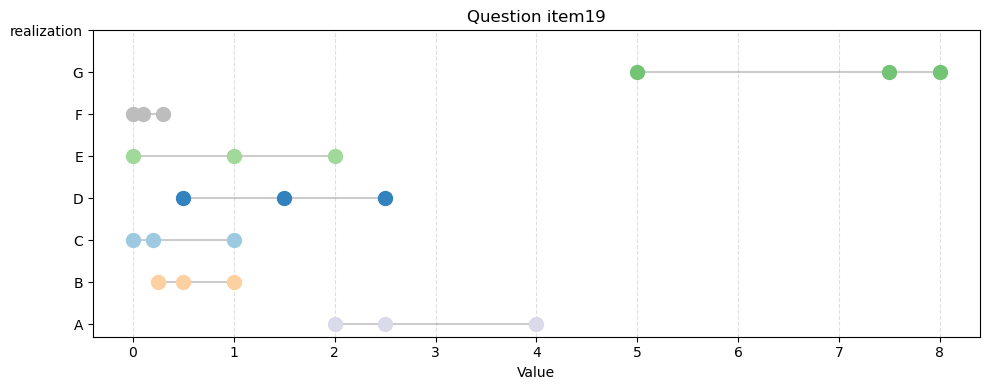

In [4]:
from collections import defaultdict
import random

# ----------------------------------------------------
# STEP 1 — Reorganize first dictionary per item
# ----------------------------------------------------
values_by_item = defaultdict(lambda: defaultdict(list))
# structure: values_by_item[item][expert] = list of values

for key, subdict in project.assessments.as_dict().items():
    for (expert, item), value in subdict.items():
        values_by_item[item][expert].append(value)

# ----------------------------------------------------
# STEP 2 — Assign consistent colors per expert
# ----------------------------------------------------
# Collect all experts across items
all_experts = set(
    expert
    for expert_dict in values_by_item.values()
    for expert in expert_dict.keys()
)
# Make sure 'realization' is included
all_experts.add("realization")

# Assign colors
expert_colors = {}
used_colors = set()
for expert in all_experts:
    if expert == "realization":
        expert_colors[expert] = "k"
    else:
        # Avoid accidentally repeating the same color
        available_colors = [c for c in plt.cm.tab20c.colors if c not in used_colors]
        if available_colors:
            color = random.choice(available_colors)
            used_colors.add(color)
            expert_colors[expert] = color
        else:
            # fallback if more experts than colors
            expert_colors[expert] = random.choice(plt.cm.tab10.colors)

# ----------------------------------------------------
# STEP 3 — Make one plot per ITEM including REALIZATION
# ----------------------------------------------------
for item, expert_dict in values_by_item.items():

    plt.figure(figsize=(10, 4))
    plt.title(f"Question {item}")

    # Add realization row if this item exists in realization_data
    if "realization" in project.items.as_dict():
        if item in project.items.as_dict()["realization"]:
            expert_dict["realization"] = [project.items.as_dict()["realization"][item]]

    # Assign y-positions (lower numbers appear lower)
    y_positions = {expert: i for i, expert in enumerate(expert_dict.keys(), start=1)}

    # Draw each expert row
    for expert, values in expert_dict.items():
        y = y_positions[expert]

        # Horizontal helper line
        if len(values) > 1:
            plt.hlines(y, min(values), max(values), colors="gray", alpha=0.4)

        # Marker shape
        marker = "*" if expert == "realization" else "o"
        color = expert_colors[expert]  # Use the fixed color

        plt.plot(
            values,
            [y] * len(values),
            marker=marker,
            color=color,
            markersize=12 if expert == "realization" else 10,
            linestyle="none",
            label=expert
        )

    # Finish formatting
    plt.yticks(list(y_positions.values()), list(y_positions.keys()))
    plt.xlabel("Value")
    plt.grid(True, axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


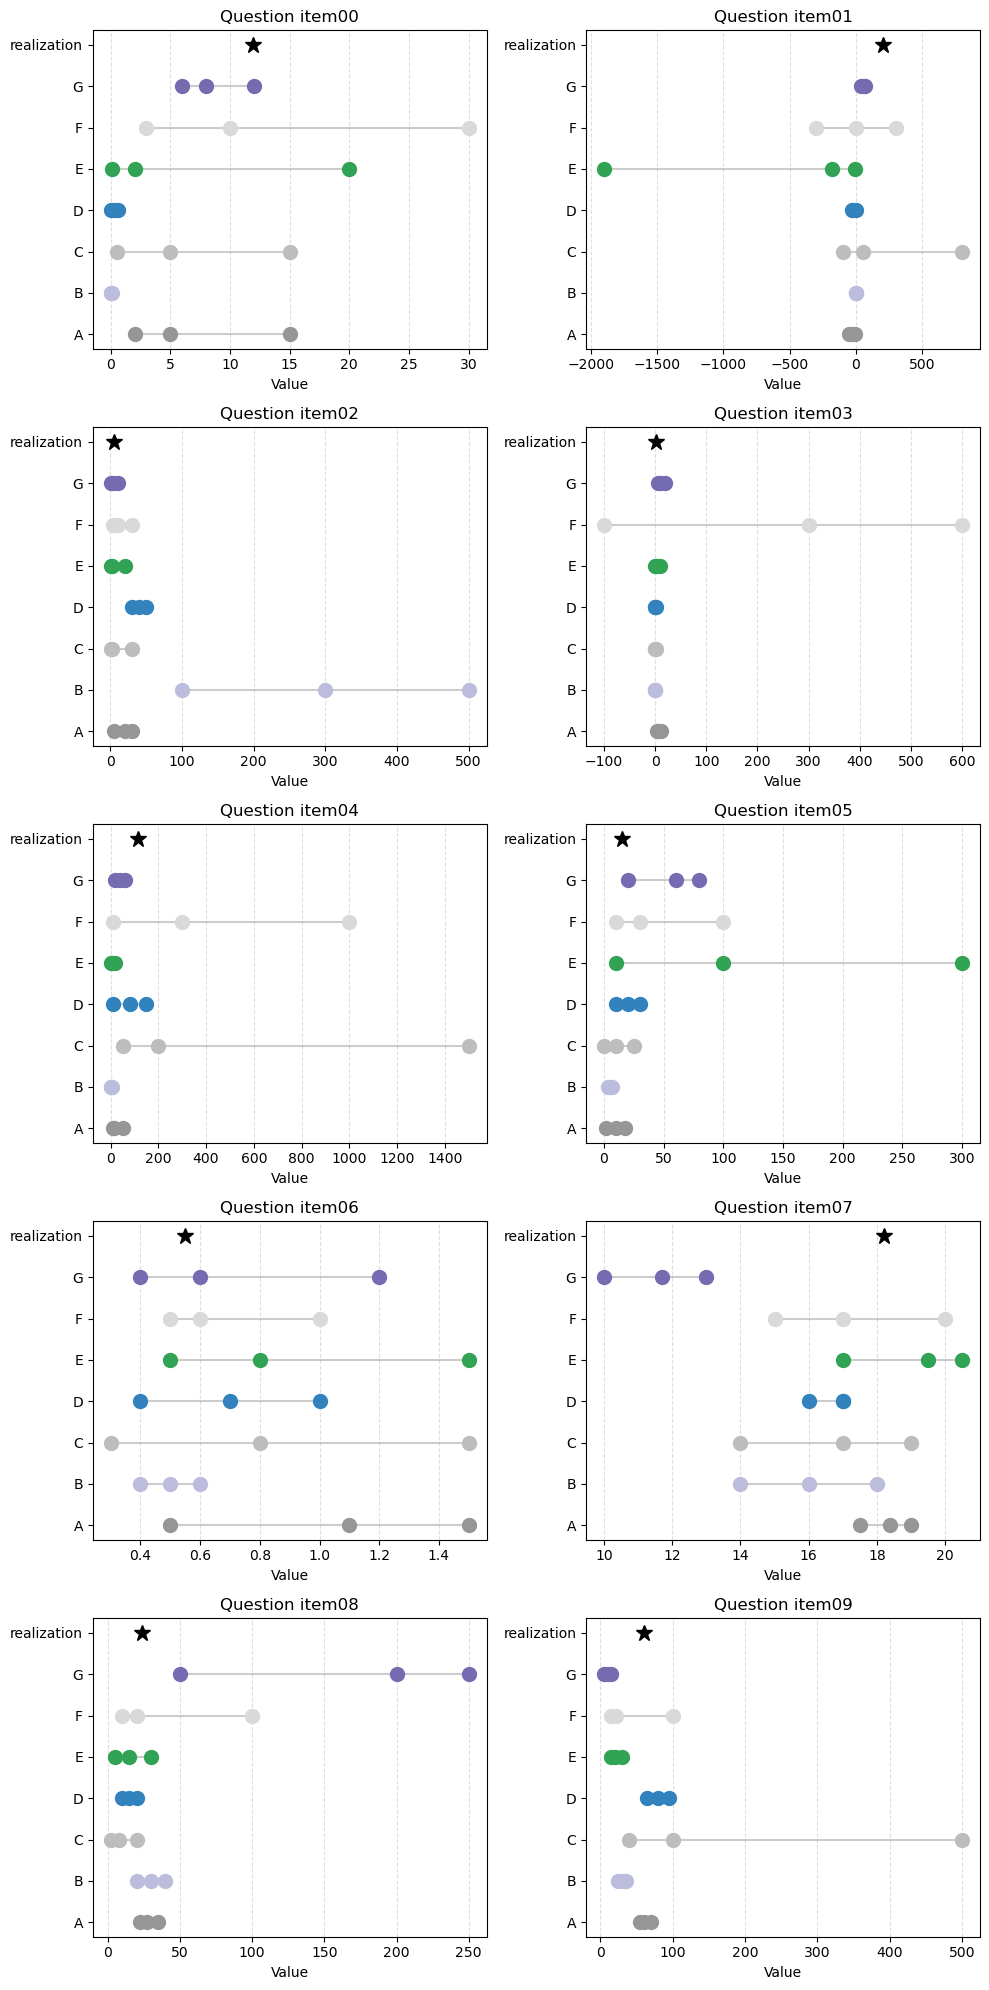

In [5]:
from collections import defaultdict
import random

# ----------------------------------------------------
# STEP 1 — Reorganize first dictionary per item
# ----------------------------------------------------
values_by_item = defaultdict(lambda: defaultdict(list))
# structure: values_by_item[item][expert] = list of values

for key, subdict in project.assessments.as_dict().items():
    for (expert, item), value in subdict.items():
        values_by_item[item][expert].append(value)

# ----------------------------------------------------
# STEP 2 — Assign consistent colors per expert
# ----------------------------------------------------
# Collect all experts across items
all_experts = set(
    expert
    for expert_dict in values_by_item.values()
    for expert in expert_dict.keys()
)
# Make sure 'realization' is included
all_experts.add("realization")

# Assign colors
expert_colors = {}
used_colors = set()
for expert in all_experts:
    if expert == "realization":
        expert_colors[expert] = "k"
    else:
        # Avoid accidentally repeating the same color
        available_colors = [c for c in plt.cm.tab20c.colors if c not in used_colors]
        if available_colors:
            color = random.choice(available_colors)
            used_colors.add(color)
            expert_colors[expert] = color
        else:
            # fallback if more experts than colors
            expert_colors[expert] = random.choice(plt.cm.tab10.colors)

# ----------------------------------------------------
# STEP 3 — Make one plot per ITEM including REALIZATION
# ----------------------------------------------------
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
axes = axes.flatten()   # makes iteration easier

for ax, (item, expert_dict) in zip(axes, values_by_item.items()):

    ax.set_title(f"Question {item}")

    # Add realization row if it exists
    if "realization" in project.items.as_dict():
        realizations = project.items.as_dict()["realization"]
        if item in realizations:
            expert_dict = expert_dict.copy()
            expert_dict["realization"] = [realizations[item]]

    # Assign y positions
    y_positions = {expert: i for i, expert in enumerate(expert_dict.keys(), start=1)}

    # Draw each expert row
    for expert, values in expert_dict.items():
        y = y_positions[expert]

        # Horizontal helper line
        if len(values) > 1:
            ax.hlines(y, min(values), max(values), colors="gray", alpha=0.4)

        # Marker shape/color
        marker = "*" if expert == "realization" else "o"
        color = expert_colors[expert]

        ax.plot(
            values,
            [y] * len(values),
            marker=marker,
            color=color,
            markersize=12 if expert == "realization" else 10,
            linestyle="none",
            label=expert
        )

    # Formatting
    ax.set_yticks(list(y_positions.values()))
    ax.set_yticklabels(list(y_positions.keys()))
    ax.set_xlabel("Value")
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

In [6]:
# Responses to the questions

pd.DataFrame.from_dict(project.assessments.as_dict())

0.05  0.50  0.95
A item00   2.0   5.0  15.0
  item01 -50.0 -40.0 -10.0
  item02   5.0  20.0  30.0
  item03   4.0   5.0  12.0
  item04  10.0  15.0  50.0
...        ...   ...   ...
G item15   2.0  10.0  20.0
  item16   0.5   2.0   5.0
  item17   4.0   6.0   7.0
  item18   5.0   7.0   7.5
  item19   5.0   7.5   8.0

[140 rows x 3 columns]

### Compute scores per expert

In [7]:
# Calculate decision maker with performance based weights
project.calculate_expert_robustness(
    weight_type='global',
    overshoot=0.1,  # this is the k factor that adjusts the range of the support
    max_exclude = 0 # this means no robustness analysis is performed  
)

We have not defined user weights: that column should remain as NaNs.

In [8]:
pd.DataFrame.from_dict(project.experts.as_dict())

,Name,Info. score total,Info. score real.,Calibration score,Answered seed items,Weight,User weight
A,A,1.929668,2.212611,3.599451e-02,12.0,7.964185e-02,NaN
B,B,2.593257,3.286677,1.149098e-07,12.0,3.776715e-07,NaN
C,C,1.462674,1.454842,2.982314e-01,12.0,4.338794e-01,NaN
D,D,2.340738,3.118967,5.589438e-07,12.0,1.743328e-06,NaN
E,E,1.645497,2.040376,1.596044e-03,12.0,3.256530e-03,NaN
F,F,1.112197,0.889327,4.701352e-01,12.0,4.181039e-01,NaN
G,G,1.827387,2.407726,1.419482e-06,12.0,3.417724e-06,NaN


### 5. Combined Score

Once the different scores are calculated, they can actually be combined into the Combined Score. The score is defined as the product of the Calibration Score and the Information Score:

$$CS(e) = Cal(e) * Inf(e)$$

This combination is relevant for the calculation of the Decision Maker and the weights required for that.

### 6. Decision Maker

When having multiple ($N$) experts, we can create what is known as de Decision Maker ($DM$) by combining the different experts using weights. The PDF and CDF of the $DM$ are as follows:

$$f_{DM} = \sum \limits _{i=1} ^{N} w_{i} f_{i}$$
$$F_{DM} = \sum \limits _{i=1} ^{N} w_{i} F_{i}$$

Where $f_{i}$ corresponds to the PDF, $F_{i}$ to the CDF and $w_{i}$ the weight assigned to the expert $i$. There are different ways to define the weights. One way is to provide equal weights to each of the experts, generating the Equal Weight DM. Another option is to make use of the $CS$ to create a Performance-based Weight $DM$. The weights for this case are defined as:

$$w_{i} = \frac{CS(e_{i})}{\sum \limits _{j=1} ^{N} CS(e_{j})}$$

On top that, if we don't want experts with very low statistical accuracy, we can impose a restriction by only using experts with a Calibration Score higher than a particulat threshold (often $0.05$, why?). 

Notice that the Decision Maker presents can be treated a another expert and its Calibration and Information Scores can be computed and compared to the actual experts.

In the following blocks, you can see an example on how to calculate a Decision Maker using Anduryl and how to make plots of the CDFs for the different questions.

In [9]:
# Calculate decision maker with global weights, using performance based
project.calculate_decision_maker(
    weight_type='global',
    overshoot=0.1,
    exp_id='DMgl_noopt',
    calpower=1.0, # Calibration power, relative weight of the calibration compared
                  # to the information score
    exp_name='Decision Maker global weights no opt',
    alpha=0,    # Significance level for the calibration score. Experts with a lower
                  # calibration score get zero weight. If None, the weights
                  # are returnes for all possible significance levels 
                  # (unique calibration scores)
    overwrite=True
)

project.experts.user_weights[0:7] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # Equal weight DM

# Calculate decision maker with user defined weights
project.calculate_decision_maker(
    weight_type='user',
    overshoot=0.1,
    exp_id='DMeq',
    calpower=1.0,
    exp_name='Decision Maker equal weights',
    alpha=0.05,
    overwrite=True
)

In [10]:
# Calculate decision maker with global weights, using performance based
project.calculate_decision_maker(
    weight_type='global',
    overshoot=0.1,
    exp_id='DMgl',
    calpower=1.0, # Calibration power, relative weight of the calibration compared
                  # to the information score
    exp_name='Decision Maker global weights',
    alpha=0.05,    # Significance level for the calibration score. Experts with a lower
                  # calibration score get zero weight. If None, the weights
                  # are returnes for all possible significance levels 
                  # (unique calibration scores)
    overwrite=True
)

The DM can be calculated in multiple ways, it can be equal weight DM, setting as 1 the user weights of each of the experts, or performance based DM which is the example shown in the code above using global.

After we calculate the DM, you can see that it appears as another expert with specific scores and weights. We have also included User weights, so that column is filled now. By looking at the weights, it falls in between the very low Expert 1 and the other two experts. In the information Score, it seems to perform worse than all the other experts but in the Calibration Score is between Experts 2 and 3. Remember that the DM is a weighted combination of the Experts.

In [11]:
pd.DataFrame.from_dict(project.experts.as_dict())

,Name,Info. score total,Info. score real.,Calibration score,Answered seed items,Weight,User weight
A,A,1.929668,2.212611,3.599451e-02,12.0,0.000000,1.0
B,B,2.593257,3.286677,1.149098e-07,12.0,0.000000,1.0
C,C,1.462674,1.454842,2.982314e-01,12.0,0.433879,1.0
D,D,2.340738,3.118967,5.589438e-07,12.0,0.000000,1.0
E,E,1.645497,2.040376,1.596044e-03,12.0,0.000000,1.0
F,F,1.112197,0.889327,4.701352e-01,12.0,0.418104,1.0
G,G,1.827387,2.407726,1.419482e-06,12.0,0.000000,1.0
DMgl_noopt,Decision Maker global weights no opt,0.774102,0.658902,4.701352e-01,NaN,0.309773,NaN
DMeq,Decision Maker equal weights,0.482184,0.567152,1.289207e-01,NaN,0.073118,NaN
DMgl,Decision Maker global weights,0.863641,0.651589,4.701352e-01,NaN,0.306335,NaN


Finally, the results the resulting PDF of the experts, including the DM, can be plotted using the CDF of each of them.

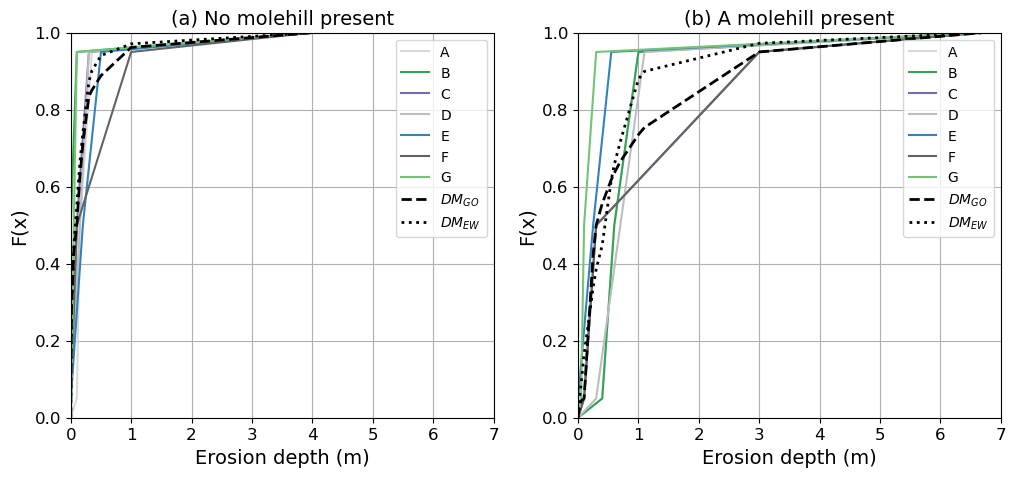

In [17]:
# setting up colors
import random

random.seed(5)
expert_colors = {}
used_colors = set()
for expert in range(7):
    available_colors = [c for c in plt.cm.tab20c.colors if c not in used_colors]
    if available_colors:
        color = random.choice(available_colors)
        used_colors.add(color)
        expert_colors[expert] = color

#select the question for which we want to plot the different CDFs
item = 'item12'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, assessment in enumerate(itemassessment):
    ax[0].plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[0].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[0].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[0].legend()

ax[0].set_title('(a) No molehill present', fontsize=14)
ax[0].set_xlabel('Erosion depth (m)', fontsize=14)
ax[0].set_ylabel('F(x)', fontsize=14)
ax[0].grid()
ax[0].set_ylim(0,1)
ax[0].set_xlim(0,7)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=12)

#select the question for which we want to plot the different CDFs
item = 'item13'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr] #added min 0


for i, assessment in enumerate(itemassessment):
    ax[1].plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[1].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[1].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[1].legend()

ax[1].set_title('(b) A molehill present', fontsize=14)
ax[1].set_xlabel('Erosion depth (m)', fontsize=14)
ax[1].set_ylabel('F(x)', fontsize=14)
ax[1].grid()
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,7)

ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)


In [14]:
#select the question for which we want the different CDFs
item = 'item12'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Experts' cdfs

def expert_cdf(lower, upper, assessment, log_scale=False, quantiles = [0.05, 0.50, 0.95]):
    expert_cdf = np.zeros([len(assessment)+2, 2])
    if log_scale:
        expert_cdf[:,1] = np.r_[np.exp(lower), assessment, np.exp(upper)]
    else:
        expert_cdf[:,1] = np.r_[np.exp(lower), assessment, np.exp(upper)]
    expert_cdf[:,0] = np.r_[0.0, quantiles[0], quantiles[1], quantiles[2], 1.0]

    return expert_cdf

expert_A_12 = expert_cdf(lower, upper, itemassessment[0], log_scale= True)
expert_B_12 = expert_cdf(lower, upper, itemassessment[1], log_scale= True)
expert_C_12 = expert_cdf(lower, upper, itemassessment[2], log_scale= True)
expert_D_12 = expert_cdf(lower, upper, itemassessment[3], log_scale= True)
expert_E_12 = expert_cdf(lower, upper, itemassessment[4], log_scale= True)
expert_F_12 = expert_cdf(lower, upper, itemassessment[5], log_scale= True)
expert_G_12 = expert_cdf(lower, upper, itemassessment[6], log_scale= True)

def eval_cdf(obs, x):
    interp_ecdf = interp1d(obs[:,1], obs[:,0], kind='linear')
    return interp_ecdf(x)

def eval_inverse_cdf(obs, x):
    inverted_ecdf = interp1d(obs[:,0], obs[:,1], kind='linear')
    return inverted_ecdf(x)

print('No moles')
print('90 percentile')
print(eval_inverse_cdf(expert_A_12, 0.9))
print(eval_inverse_cdf(expert_B_12, 0.9))
print(eval_inverse_cdf(expert_C_12, 0.9))
print(eval_inverse_cdf(expert_D_12, 0.9))
print(eval_inverse_cdf(expert_E_12, 0.9))
print(eval_inverse_cdf(expert_F_12, 0.9))
print(eval_inverse_cdf(expert_G_12, 0.9))
print(eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], 0.9))
print(eval_cdf(project.assessments.full_cdf['DMeq'][itemnr], 0.9))

print('50 percentile')
print(eval_inverse_cdf(expert_A_12, 0.5))
print(eval_inverse_cdf(expert_B_12, 0.5))
print(eval_inverse_cdf(expert_C_12, 0.5))
print(eval_inverse_cdf(expert_D_12, 0.5))
print(eval_inverse_cdf(expert_E_12, 0.5))
print(eval_inverse_cdf(expert_F_12, 0.5))
print(eval_inverse_cdf(expert_G_12, 0.5))
print(eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], 0.5))
print(eval_cdf(project.assessments.full_cdf['DMeq'][itemnr], 0.5))


No moles
90 percentile
0.32777777777777783
0.08890000000000002
0.2777777777777778
0.2833333333333333
0.46666666666666673
0.9000000000000002
0.09444444444444446
0.5780782168536291
0.34756626541671276
50 percentile
0.15
0.0001
0.1
0.15
0.2
0.1
0.05
0.10000000000000002
0.07649112545102585


In [15]:
#select the question for which we want the different CDFs
item = 'item13'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

expert_A_13 = expert_cdf(lower, upper, itemassessment[0], log_scale= True)
expert_B_13 = expert_cdf(lower, upper, itemassessment[1], log_scale= True)
expert_C_13 = expert_cdf(lower, upper, itemassessment[2], log_scale= True)
expert_D_13 = expert_cdf(lower, upper, itemassessment[3], log_scale= True)
expert_E_13 = expert_cdf(lower, upper, itemassessment[4], log_scale= True)
expert_F_13 = expert_cdf(lower, upper, itemassessment[5], log_scale= True)
expert_G_13 = expert_cdf(lower, upper, itemassessment[6], log_scale= True)

print('With moles', eval_inverse_cdf(expert_A_13, 0.9))
print(eval_inverse_cdf(expert_B_13, 0.9))
print(eval_inverse_cdf(expert_C_13, 0.9))
print(eval_inverse_cdf(expert_D_13, 0.9))
print(eval_inverse_cdf(expert_E_13, 0.9))
print(eval_inverse_cdf(expert_F_13, 0.9))
print(eval_inverse_cdf(expert_G_13, 0.9))
print(eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], 0.9))
print(eval_cdf(project.assessments.full_cdf['DMeq'][itemnr], 0.9))

print('50 percentile')
print(eval_inverse_cdf(expert_A_13, 0.5))
print(eval_inverse_cdf(expert_B_13, 0.5))
print(eval_inverse_cdf(expert_C_13, 0.5))
print(eval_inverse_cdf(expert_D_13, 0.5))
print(eval_inverse_cdf(expert_E_13, 0.5))
print(eval_inverse_cdf(expert_F_13, 0.5))
print(eval_inverse_cdf(expert_G_13, 0.5))
print(eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], 0.5))
print(eval_cdf(project.assessments.full_cdf['DMeq'][itemnr], 0.5))

With moles 0.9555555555555556
0.9555555555555556
2.7
1.0555555555555558
0.5166666666666668
2.7
0.2777777777777778
2.515498579026859
1.108673761899774
50 percentile
0.6
0.6
0.3
0.7
0.25
0.3
0.1
0.3
0.4457175042927706


(-2.0, 8.0)

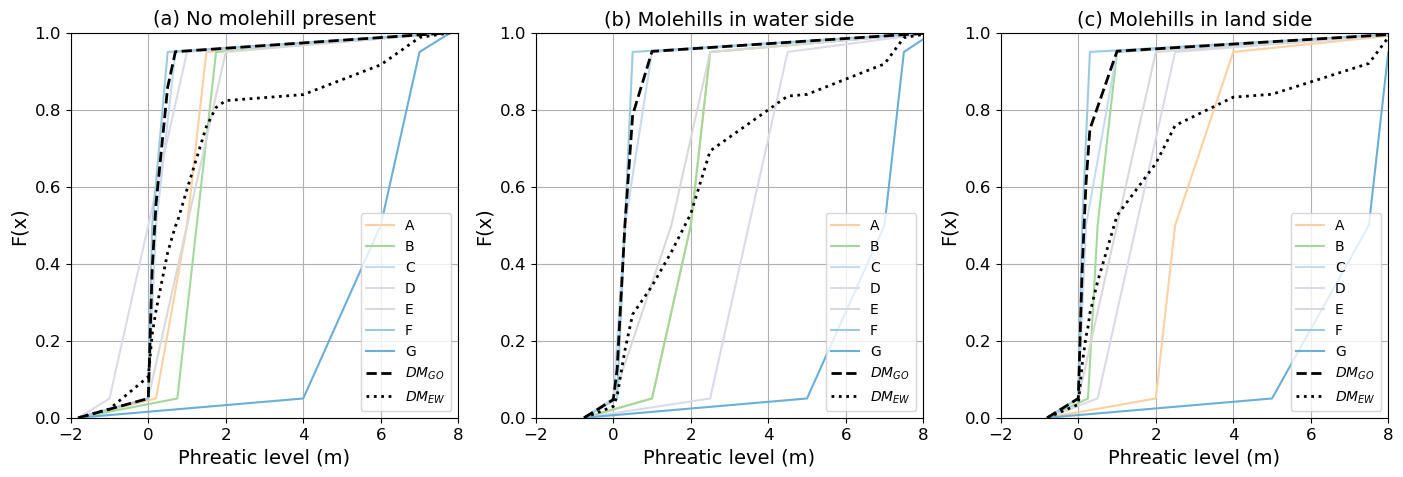

In [16]:
#select the question for which we want to plot the different CDFs
item = 'item17'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

for i, assessment in enumerate(itemassessment):
    ax[0].plot(np.r_[lower, assessment, upper], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[0].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[0].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[0].legend(loc = 'lower right')

ax[0].set_title('(a) No molehill present', fontsize=14)
ax[0].set_xlabel('Phreatic level (m)', fontsize=14)
ax[0].set_ylabel('F(x)', fontsize=14)
ax[0].grid()
ax[0].set_ylim(0,1)
ax[0].set_xlim(-2, 8)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=12)

#select the question for which we want to plot the different CDFs
item = 'item18'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]


for i, assessment in enumerate(itemassessment):
    ax[1].plot(np.r_[lower, assessment, upper], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[1].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[1].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[1].legend(loc = 'lower right')

ax[1].set_title('(b) Molehills in water side', fontsize=14)
ax[1].set_xlabel('Phreatic level (m)', fontsize=14)
ax[1].set_ylabel('F(x)', fontsize=14)
ax[1].grid()
ax[1].set_ylim(0,1)
ax[1].set_xlim(-2, 8)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

#select the question for which we want to plot the different CDFs
item = 'item19'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]


for i, assessment in enumerate(itemassessment):
    ax[2].plot(np.r_[lower, assessment, upper], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[2].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[2].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[2].legend(loc = 'lower right')

ax[2].set_title('(c) Molehills in land side', fontsize=14)
ax[2].set_xlabel('Phreatic level (m)', fontsize=14)
ax[2].set_ylabel('F(x)', fontsize=14)
ax[2].grid()
ax[2].set_ylim(0,1)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].tick_params(axis='both', which='minor', labelsize=12)
ax[2].set_xlim(-2, 8)


In [40]:
#select the question for which we want the different CDFs
item = 'item17'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

expert_A_17 = expert_cdf(lower, upper, itemassessment[0], log_scale= True)
expert_B_17 = expert_cdf(lower, upper, itemassessment[1], log_scale= True)
expert_C_17 = expert_cdf(lower, upper, itemassessment[2], log_scale= True)
expert_D_17 = expert_cdf(lower, upper, itemassessment[3], log_scale= True)
expert_E_17 = expert_cdf(lower, upper, itemassessment[4], log_scale= True)
expert_F_17 = expert_cdf(lower, upper, itemassessment[5], log_scale= True)
expert_G_17 = expert_cdf(lower, upper, itemassessment[6], log_scale= True)

print('Without moles', eval_inverse_cdf(expert_A_17, 0.9))
print(eval_inverse_cdf(expert_B_17, 0.9))
print(eval_inverse_cdf(expert_C_17, 0.9))
print(eval_inverse_cdf(expert_D_17, 0.9))
print(eval_inverse_cdf(expert_E_17, 0.9))
print(eval_inverse_cdf(expert_F_17, 0.9))
print(eval_inverse_cdf(expert_G_17, 0.9))
print(eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], 0.9))
print(eval_cdf(project.assessments.full_cdf['DMeq'][itemnr], 0.9))

Without moles 1.4444444444444444
1.6944444444444444
0.6444444444444445
0.888888888888889
1.8888888888888888
0.4555555555555556
6.888888888888889
0.5902469954746307
5.568072645783384


In [41]:
#select the question for which we want the different CDFs
item = 'item18'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

expert_A_18 = expert_cdf(lower, upper, itemassessment[0], log_scale= True)
expert_B_18 = expert_cdf(lower, upper, itemassessment[1], log_scale= True)
expert_C_18 = expert_cdf(lower, upper, itemassessment[2], log_scale= True)
expert_D_18 = expert_cdf(lower, upper, itemassessment[3], log_scale= True)
expert_E_18 = expert_cdf(lower, upper, itemassessment[4], log_scale= True)
expert_F_18 = expert_cdf(lower, upper, itemassessment[5], log_scale= True)
expert_G_18 = expert_cdf(lower, upper, itemassessment[6], log_scale= True)

print('Water side', eval_inverse_cdf(expert_A_18, 0.9))
print(eval_inverse_cdf(expert_B_18, 0.9))
print(eval_inverse_cdf(expert_C_18, 0.9))
print(eval_inverse_cdf(expert_D_18, 0.9))
print(eval_inverse_cdf(expert_E_18, 0.9))
print(eval_inverse_cdf(expert_F_18, 0.9))
print(eval_inverse_cdf(expert_G_18, 0.9))
print(eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], 0.9))
print(eval_cdf(project.assessments.full_cdf['DMeq'][itemnr], 0.9))

Water side 2.4444444444444446
2.4444444444444446
0.9222222222222223
4.388888888888889
2.388888888888889
0.4777777777777778
7.444444444444445
0.8439460839065678
6.5174418486551735


In [42]:
#select the question for which we want the different CDFs
item = 'item19'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

expert_A_19 = expert_cdf(lower, upper, itemassessment[0], log_scale= True)
expert_B_19 = expert_cdf(lower, upper, itemassessment[1], log_scale= True)
expert_C_19 = expert_cdf(lower, upper, itemassessment[2], log_scale= True)
expert_D_19 = expert_cdf(lower, upper, itemassessment[3], log_scale= True)
expert_E_19 = expert_cdf(lower, upper, itemassessment[4], log_scale= True)
expert_F_19 = expert_cdf(lower, upper, itemassessment[5], log_scale= True)
expert_G_19 = expert_cdf(lower, upper, itemassessment[6], log_scale= True)

print('Land side', eval_inverse_cdf(expert_A_19, 0.9))
print(eval_inverse_cdf(expert_B_19, 0.9))
print(eval_inverse_cdf(expert_C_19, 0.9))
print(eval_inverse_cdf(expert_D_19, 0.9))
print(eval_inverse_cdf(expert_E_19, 0.9))
print(eval_inverse_cdf(expert_F_19, 0.9))
print(eval_inverse_cdf(expert_G_19, 0.9))
print(eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], 0.9))
print(eval_cdf(project.assessments.full_cdf['DMeq'][itemnr], 0.9))

Land side 3.8333333333333335
0.9444444444444444
0.9111111111111112
2.388888888888889
1.8888888888888888
0.2777777777777778
7.944444444444445
0.8202118099655511
6.866031060703959


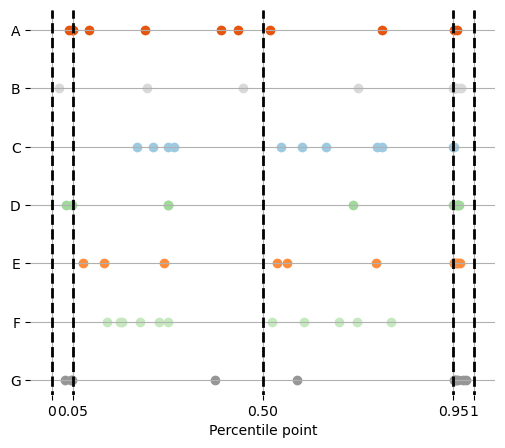

In [16]:
# Plot of realizations in the experts' distributions
from scipy.interpolate import interp1d

def eval_ecdf(obs, x):
    interp_ecdf = interp1d(obs[0], obs[1])
    return interp_ecdf(x)

# p vector
p = [0, 0.05, 0.5, 0.95, 1]

# realizations
realizations = pd.DataFrame.from_dict(project.items.as_dict())

# bounds
bounds = project.assessments.get_bounds(overshoot=0.1)

# select the question for which we want to plot the different CDFs
itemnr = np.linspace(1, 12, 12)

fig, ax = plt.subplots(figsize=(6, 5))

# Get experts assessments for the item
for i in itemnr: #for each item
    i = int(i)

    #extract assessments for item i, each row an expert
    itemassessment = project.assessments.get_array(experts='actual')[:, :, i]

    # Get bounds for the item i
    lower, upper = bounds[0][i], bounds[1][i]

    for j in range(7): #for each expert
        vals = [lower, itemassessment[j][0], itemassessment[j][1], itemassessment[j][2], upper]
        ax.scatter(eval_ecdf(np.array([vals, p]), realizations['realization'][i]), 6-j, 
                   color = expert_colors[j])

ax.set_xlabel('Percentile point')
ax.set_yticks([0, 1, 2, 3, 4, 5, 6])
ax.set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A'])
ax.set_xticks([0, 0.05, 0.50, 0.95, 1])
ax.set_xticklabels(['0', '0.05', '0.50', '0.95', '1'])
ax.plot([0, 0], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([0.05, 0.05], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([0.5, 0.5], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([0.95, 0.95], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([1, 1], [-0.35, 6.35], '--k', linewidth = 2)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.25,6.35)
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

### 7. Robustness

A way of checking the robustness of the project is by removing one or multiple items or experts from the project in turn, and checking the resulting information and calibration scores. If these values will change a lot, it shows that the number of items or experts might be a bit too low.

In [17]:
# Exclude up to four items
project.calculate_item_robustness(
    weight_type='global',
    overshoot=0.1,
    max_exclude=4,
    min_exclude=0,
    calpower=1.0,
    alpha=0.05
)

In the next table, you can see the score changes when different questions are extracted of the calculations. As this is an artifitial example, the Calibration Score has a extrange behaviour, where there is no change of the score or only one single change when one or multiple questions are removed. You are now encouraged to take some of the examples on the github repository that you will find at the end of this notebook and try some of the different examples you can find there.

In [18]:
robres = project.main_results.item_robustness
index = [val[:] if val else 'None' for val in list(robres.keys())]
pd.DataFrame(data=robres.values(), index=index, columns=['Info score total' ,'Info score realizations', 'Calibration score'])

,Info score total,Info score realizations,Calibration score
None,0.863641,0.651589,0.470135
"(item00,)",0.899697,0.694566,0.491968
"(item01,)",0.764282,0.651082,0.369574
"(item02,)",0.676579,0.520349,0.491968
"(item03,)",0.785330,0.694578,0.491968
...,...,...,...
"(item07, item08, item09, item10)",0.994689,0.791408,0.640102
"(item07, item08, item09, item11)",0.956361,0.730117,0.640102
"(item07, item08, item10, item11)",0.976203,0.768400,0.533701
"(item07, item09, item10, item11)",0.776191,0.709398,0.533701


When more questions are extracted, the variation of the Information Score grows. This means that the calculations results are more sensitive when more questions are extracted.

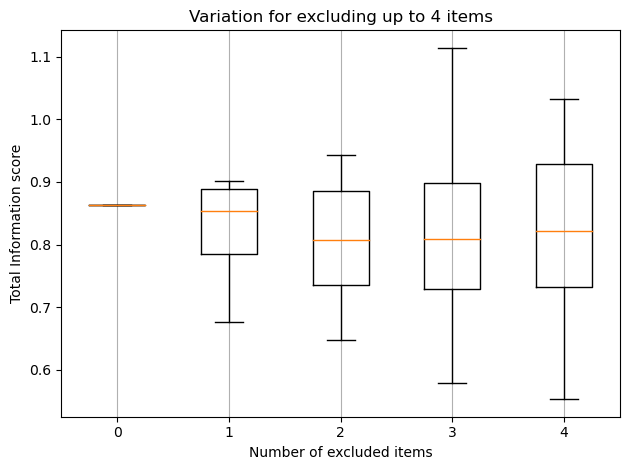

In [19]:
# Collect the results per number of excluded items
robres = project.main_results.item_robustness
values = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values.keys():
        values[len(key)] = []
    # Append total information score (the 1st value)
    values[len(key)].append(value[0])
        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots()
ax.boxplot(values.values(), positions=list(values.keys()));
ax.set_xlabel('Number of excluded items')
ax.set_ylabel('Total Information score')
ax.set_title('Variation for excluding up to 4 items');
ax.grid(axis='x')
fig.tight_layout()

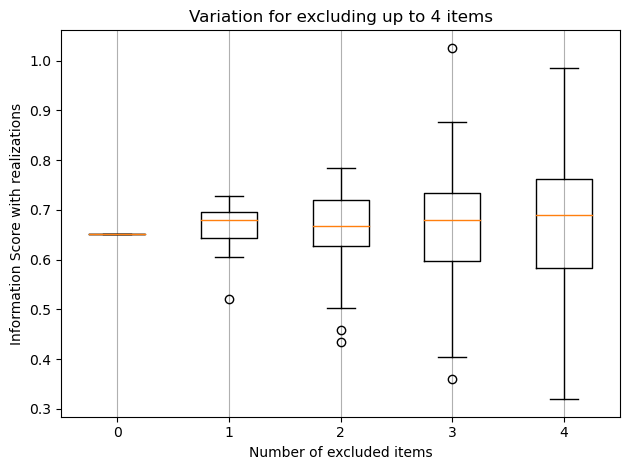

In [20]:
# Collect the results per number of excluded items
robres = project.main_results.item_robustness
values = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values.keys():
        values[len(key)] = []
    # Append information score with realizations
    values[len(key)].append(value[1])
        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots()
ax.boxplot(values.values(), positions=list(values.keys()));
ax.set_xlabel('Number of excluded items')
ax.set_ylabel('Information Score with realizations')
ax.set_title('Variation for excluding up to 4 items');
ax.grid(axis='x')
fig.tight_layout()

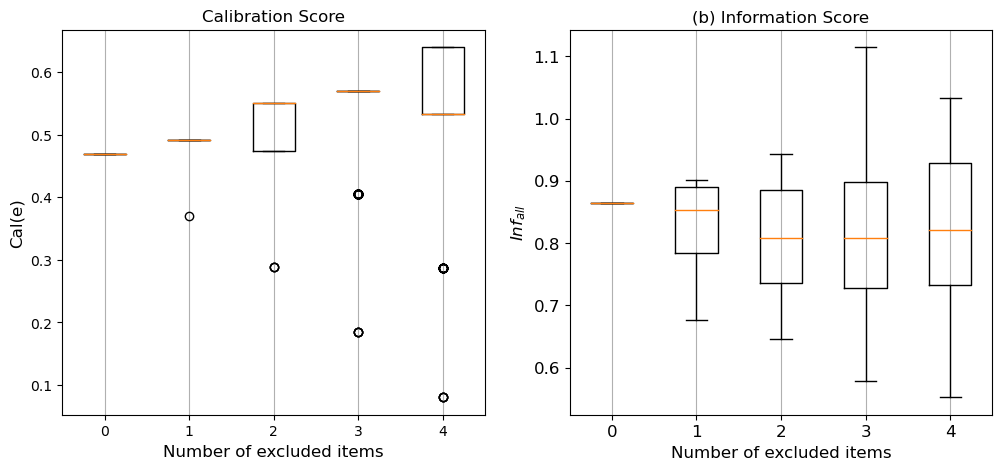

In [21]:
# Collect the results per number of excluded items: calibration
robres = project.main_results.item_robustness
values = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values.keys():
        values[len(key)] = []
    # Append calibration score (the 3th value, index 2 since Python is zero-based)
    values[len(key)].append(value[2])

# Collect the results per number of excluded items: information
values_inf = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values_inf.keys():
        values_inf[len(key)] = []
    # Append total information score (the 1st value)
    values_inf[len(key)].append(value[0])
        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].boxplot(values.values(), positions=list(values.keys()));
ax[0].set_xlabel('Number of excluded items', fontsize=12)
ax[0].set_ylabel('Cal(e)', fontsize=12)
ax[0].set_title('Calibration Score', fontsize=12);
ax[0].grid(axis='x')
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

ax[1].boxplot(values_inf.values(), positions=list(values.keys()));
ax[1].set_xlabel('Number of excluded items', fontsize=12)
ax[1].set_ylabel('${Inf_{all}}$', fontsize=12)
ax[1].set_title('(b) Information Score', fontsize=12);
ax[1].grid(axis='x')
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

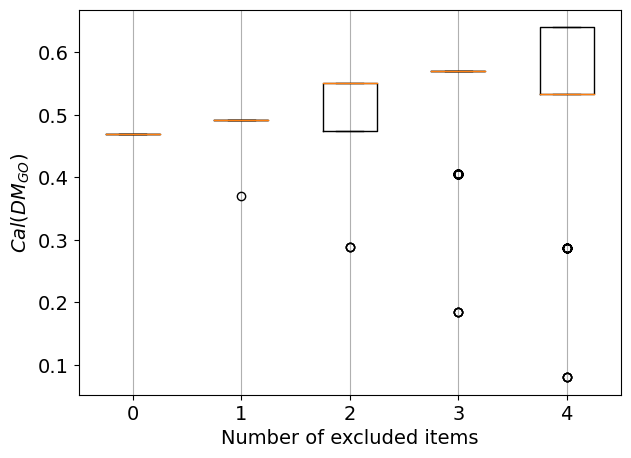

In [22]:
# Collect the results per number of excluded items: calibration
robres = project.main_results.item_robustness
values = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values.keys():
        values[len(key)] = []
    # Append calibration score (the 3th value, index 2 since Python is zero-based)
    values[len(key)].append(value[2])

        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.boxplot(values.values(), positions=list(values.keys()));
ax.set_xlabel('Number of excluded items', fontsize=14)
ax.set_ylabel('${Cal(DM_{GO})}$', fontsize=14)
# ax.set_title('Calibration Score', fontsize=12);
ax.grid(axis='x')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)


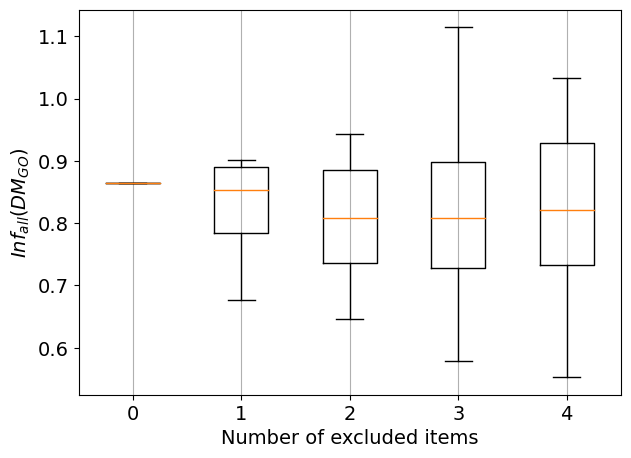

In [23]:
# Collect the results per number of excluded items: calibration
robres = project.main_results.item_robustness

# Collect the results per number of excluded items: information
values_inf = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values_inf.keys():
        values_inf[len(key)] = []
    # Append total information score (the 1st value)
    values_inf[len(key)].append(value[0])
        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.boxplot(values_inf.values(), positions=list(values.keys()));
ax.set_xlabel('Number of excluded items', fontsize=14)
ax.set_ylabel('${Inf_{all}(DM_{GO})}$', fontsize=14)
# ax.set_title('(b) Information Score', fontsize=12);
ax.grid(axis='x')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

### Overtopping erosion